#QML-HEP GSoC 2023 Task Solutions 


##TASK VII

In this task you are supposed to get started with equivariant quantum neural networks by implementing a Z_2 × Z_2 equivariant quantum neural network. Z_2 is a symmetry group an as an example we will generate a simple classical dataset which is respects the Z_2 x Z_2 symmetry.

This example is explained in the paper https://arxiv.org/abs/2205.06217 and additional background can be found in https://arxiv.org/abs/2210.08566.


* Generate a classification dataset with two classes and two features x_1 and x_2 which respects the Z_2 x Z_2 symmetry (this corresponds to mirroring along y=x)An example can be found in the first reference paper.
* Train a QNN to solve the classification problem
* Train an Z_2 x Z_2 equivariant QNN to solve the classification problem and compare the results.

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt

We will create a dataset for classification with two features (x_1 and x_2) and two classes. The dataset will have a Z_2 x Z_2 symmetry and will contain two circles. The outer circle will have points labeled as Class 0 and the inner circle will have points labeled as Class 1. The circles will be concentric, meaning that they have the same center.

In [ ]:
import numpy as np
from sklearn.datasets import make_circles

# Generate dataset of 1000 samples with 2 features
# The circles will have a noise of 0.05, and the inner circle will have a radius of 0.5
# Use a random seed of 42 for reproducibility
X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=42)

# Convert data to float32 and integer64 types, respectively
X_circles = X_circles.astype(np.float32)
y_circles = y_circles.astype(np.int64)

# Label points inside the circle as Class 1 and outside the circle as Class 0
y = np.logical_not(y_circles).astype(np.int64)

# Apply Z2 x Z2 symmetry transformation by swapping the two features of each sample
X_symmetry = np.stack((X_circles[:, 1], X_circles[:, 0]), axis=1)
X = np.concatenate((X_circles, X_symmetry), axis=0)
y = np.concatenate((y, y), axis=0)


In [ ]:
print(X)

[[ 0.45259237  0.16843331]
 [-0.43802652  0.11990049]
 [-0.5322243   0.18435901]
 ...
 [-0.531447   -0.07201617]
 [-0.7931901   0.6609045 ]
 [ 0.96735954  0.2784149 ]]


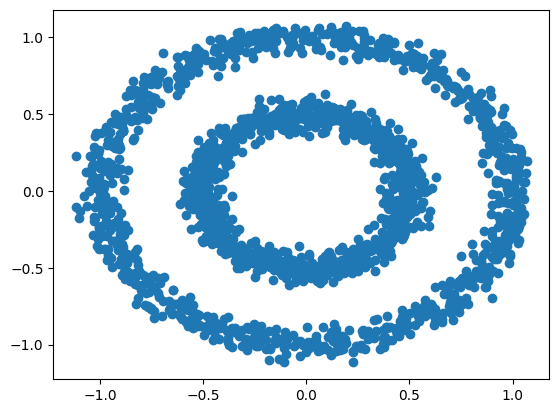

In [ ]:
#visualizing dataset
plt.scatter(X[:,0], X[:,1])
plt.show()

In [ ]:
print(y)

[0 0 0 ... 0 1 1]


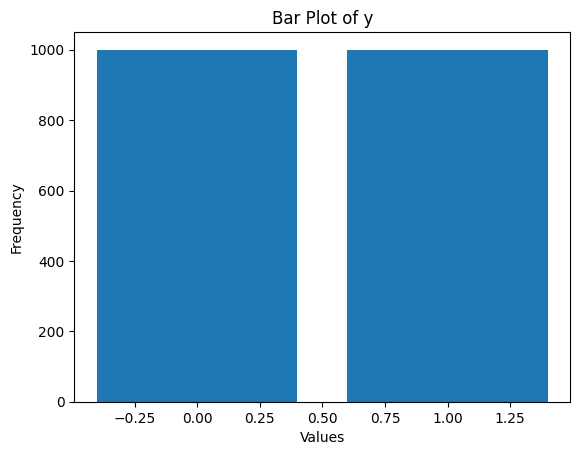

In [ ]:
#visualizing label frequency 
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Bar Plot of y')
plt.show()

Spliting the Dataset into Test and Train with ratio 80:20 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import pennylane as qml
from pennylane import numpy as np

def train_qnn(X_train, y_train, X_test, y_test, n_qubits=2, n_epochs=200, batch_size=32, learning_rate=0.1):
    """
    Trains a quantum neural network (QNN) using the provided training data and evaluates the accuracy on the test set
    after each epoch. The QNN consists of two RX gates on each qubit with the input features, a CNOT gate between qubits
    0 and 1, three trainable parameters, and an expectation value measurement of PauliZ on qubit 0. The QNN is trained
    using gradient descent optimization with the provided learning rate.

    Args:
        X_train (array): An array of shape (n_train, n_features) containing the training input features.
        y_train (array): An array of shape (n_train,) containing the training target labels (-1 or 1).
        X_test (array): An array of shape (n_test, n_features) containing the test input features.
        y_test (array): An array of shape (n_test,) containing the test target labels (-1 or 1).
        n_qubits (int): The number of qubits in the QNN circuit. Defaults to 2.
        n_epochs (int): The number of epochs to train the QNN. Defaults to 200.
        batch_size (int): The size of each mini-batch used during training. Defaults to 32.
        learning_rate (float): The learning rate used during gradient descent optimization. Defaults to 0.1.

    Returns:
        None
    """

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def qnn_circuit(x, weights):
        """
          Quantum circuit for the quantum neural network. Applies RX and RZ gates to each qubit, and
          CNOT gates between qubits 0 and 1. The weights are used as parameters for the gates.

          Args:
              x (array): Input features.
              weights (array): Weights used as parameters for the quantum gates.

          Returns:
              float: Expectation value of PauliZ on qubit 0.
          """
        # Apply RX gates to each qubit with the input features
        for i in range(n_qubits):
            qml.RX(x[i], wires=i)

        # Apply CNOT gate between qubits 0 and 1
        qml.CNOT(wires=[0, 1])

        # Apply RZ gates to each qubit with the first two weights
        qml.RZ(weights[0], wires=0)
        qml.CNOT(wires=[0, 1])
        qml.RZ(weights[1], wires=1)

        # Apply RX gates to each qubit with the remaining weights
        for i in range(n_qubits):
            qml.RX(weights[2+i]*np.pi, wires=i)

        # Measure the expectation value of PauliZ on qubit 0
        return qml.expval(qml.PauliZ(0))

    # Define the quantum neural network loss function
    def qnn_loss(weights, X, y):
        """
        Loss function for the quantum neural network. Calculates the mean squared error between the
        output of the quantum circuit and the target output.

        Args:
            weights (array): Weights used as parameters for the quantum gates.
            X (array): Input features.
            y (array): Target output.

        Returns:
            float: Mean squared error between the output of the quantum circuit and the target output.
        """
        loss = 0
        for i in range(len(X)):
            output = qnn_circuit(X[i], weights)
            loss += (output - (-1)**y[i]) ** 2
        return loss / len(X)

    # Set the random seed and initialize the weights
    np.random.seed(32)
    weights = np.random.rand(n_qubits+3)

    # Define the optimizer and hyperparameters
    opt = qml.GradientDescentOptimizer(learning_rate)

    # Train the quantum neural network
    for epoch in range(n_epochs):
        if epoch == 100:
          opt = qml.GradientDescentOptimizer(learning_rate/10)
        permutation = np.random.permutation(len(X_train))
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        # Divide the training data into batches
        n_batches = len(X_train) // batch_size

        for i in range(n_batches):
            # Select the next batch
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            y_batch = y_train[i*batch_size:(i+1)*batch_size]

            # Update the weights using the gradient descent optimizer
            weights = opt.step(lambda w: qnn_loss(w, X_batch, y_batch), weights)

        # Evaluate the accuracy on the test set after each epoch
        y_pred = [qml.math.sign(qnn_circuit(x, weights)) for x in X_test]
        acc = np.sum(y_pred == y_test) / len(y_test)
        print(f"Epoch {epoch+1}/{n_epochs}, Test accuracy: {acc:.3f}")

train_qnn(X_train, y_train, X_test, y_test)

Epoch 1/200, Test accuracy: 0.000
Epoch 2/200, Test accuracy: 0.000
Epoch 3/200, Test accuracy: 0.000
Epoch 4/200, Test accuracy: 0.512
Epoch 5/200, Test accuracy: 0.407
Epoch 6/200, Test accuracy: 0.512
Epoch 7/200, Test accuracy: 0.000
Epoch 8/200, Test accuracy: 0.000
Epoch 9/200, Test accuracy: 0.512
Epoch 10/200, Test accuracy: 0.512
Epoch 11/200, Test accuracy: 0.000
Epoch 12/200, Test accuracy: 0.512
Epoch 13/200, Test accuracy: 0.135
Epoch 14/200, Test accuracy: 0.512
Epoch 15/200, Test accuracy: 0.512
Epoch 16/200, Test accuracy: 0.185
Epoch 17/200, Test accuracy: 0.000
Epoch 18/200, Test accuracy: 0.500
Epoch 19/200, Test accuracy: 0.228
Epoch 20/200, Test accuracy: 0.083
Epoch 21/200, Test accuracy: 0.000
Epoch 22/200, Test accuracy: 0.000
Epoch 23/200, Test accuracy: 0.512
Epoch 24/200, Test accuracy: 0.512
Epoch 25/200, Test accuracy: 0.512
Epoch 26/200, Test accuracy: 0.512
Epoch 27/200, Test accuracy: 0.000
Epoch 28/200, Test accuracy: 0.000
Epoch 29/200, Test accuracy: 

In [ ]:
print(f"Final test accuracy: {acc:.3f}")

Final test accuracy: 0.512


In [ ]:
@qml.qnode(dev)
def qnn_circuit_sym(x, weights):
    # apply Hadamard gates
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    for i in range(n_qubits):
        qml.RX(x[i], wires=i)

    # apply Hadamard gates
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    qml.CNOT(wires=[0, 1])

    # apply Hadamard gates
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    qml.RZ(weights[0], wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RZ(weights[1], wires=1)

    # apply Hadamard gates
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    for i in range(n_qubits):
        qml.RX(x[i], wires=i)

    # apply Hadamard gates
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # apply RX gates with an additional angle parameter
    for i in range(n_qubits):
        qml.RX(weights[2+i]*np.pi, wires=i)

    # measure the expectation value of Pauli-Z on the first wire
    return qml.expval(qml.PauliZ(0))


In [ ]:
def qnn_loss_sym(weights, X, y_true):
    loss = 0
    for i in range(len(X)):
        # apply the symmetry transformation
        X_sym = [X[i][1], X[i][0]]
        y_sym = y_true[i]

        # compute the output of the QNN for the symmetric input
        y_pred = qnn_circuit_sym(X_sym, weights)

        # compute the loss for the symmetric input
        loss += (y_sym - y_pred) ** 2

        # compute the output of the QNN for the original input
        y_pred_sym = qnn_circuit_sym(X[i], weights)

        # compute the loss for the original input
        loss += (y_true[i] - y_pred_sym) ** 2

    return loss / (2 * len(X))


In [ ]:
np.random.seed(42)
weights = np.random.rand(n_qubits+3)
opt = qml.GradientDescentOptimizer(0.1)

n_epochs = 200
batch_size = 32
n_batches = len(X_train) // batch_size

for epoch in range(n_epochs):
    # shuffle the training data
    if epoch == 100:
      opt = qml.GradientDescentOptimizer(0.01)
    permutation = np.random.permutation(len(X_train))
    X_train = X_train[permutation]
    y_train = y_train[permutation]

    for i in range(n_batches):
        # select the next batch
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        # update the weights
        weights = opt.step(lambda w: qnn_loss_sym(w, X_batch, y_batch), weights)

    # compute the accuracy on the test set
    y_pred = [qml.math.sign(qnn_circuit_sym(x, weights)) for x in X_test]
    acc = np.sum(y_pred == y_test) / len(y_test)

    print(f"Epoch {epoch+1}/{n_epochs}, Test accuracy: {acc:.3f}")


Epoch 1/200, Test accuracy: 0.510
Epoch 2/200, Test accuracy: 0.512
Epoch 3/200, Test accuracy: 0.512
Epoch 4/200, Test accuracy: 0.512
Epoch 5/200, Test accuracy: 0.512
Epoch 6/200, Test accuracy: 0.512
Epoch 7/200, Test accuracy: 0.512
Epoch 8/200, Test accuracy: 0.512
Epoch 9/200, Test accuracy: 0.512
Epoch 10/200, Test accuracy: 0.512
Epoch 11/200, Test accuracy: 0.512
Epoch 12/200, Test accuracy: 0.512
Epoch 13/200, Test accuracy: 0.512
Epoch 14/200, Test accuracy: 0.512
Epoch 15/200, Test accuracy: 0.512
Epoch 16/200, Test accuracy: 0.512
Epoch 17/200, Test accuracy: 0.512
Epoch 18/200, Test accuracy: 0.512
Epoch 19/200, Test accuracy: 0.512
Epoch 20/200, Test accuracy: 0.512
Epoch 21/200, Test accuracy: 0.512
Epoch 22/200, Test accuracy: 0.512
Epoch 23/200, Test accuracy: 0.512
Epoch 24/200, Test accuracy: 0.512
Epoch 25/200, Test accuracy: 0.512
Epoch 26/200, Test accuracy: 0.512
Epoch 27/200, Test accuracy: 0.512
Epoch 28/200, Test accuracy: 0.512
Epoch 29/200, Test accuracy: 

In [ ]:
print(f"Final test accuracy: {acc:.3f}")

Final test accuracy: 0.512
